# CLIP BASE + T5 BASE

### Código del modelo

In [2]:
# Importar modelos y tokenizadores de transformers
from transformers import CLIPModel, CLIPTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import torch.nn as nn
import pytorch_lightning as pl
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader
import json
import os
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from evaluate import load
import re
import matplotlib.pyplot as plt

# Definición del modelo que combina CLIP y T5
class VisionTextModel(nn.Module):
    def __init__(self):
        super(VisionTextModel, self).__init__()
        # Cargar modelo CLIP preentrenado
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        # Cargar modelo T5 preentrenado
        self.t5 = T5ForConditionalGeneration.from_pretrained("t5-base")
        # Cambiar la dimensión de 768 (salida de CLIP) a 768 (entrada de T5-base)
        self.linear = nn.Linear(768, 768)

    def forward(self, pixel_values, decoder_input_ids, decoder_attention_mask=None, labels=None):
        # Obtener características de la imagen usando CLIP
        clip_outputs = self.clip.vision_model(pixel_values=pixel_values)
        # Adaptar las dimensiones de las características de CLIP de 768 a 768
        adapted_encoder_outputs = self.linear(clip_outputs.last_hidden_state)
        visual_features = adapted_encoder_outputs

        # Añadir una dimensión si es necesario (para el batch) para que encajen los tensores
        if visual_features.ndim == 2:
            visual_features = visual_features.unsqueeze(1)

        # Pasar las características visuales adaptadas al modelo T5 como entrada del decodificador
        t5_outputs = self.t5(
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            encoder_outputs=(visual_features,),
            labels=labels
        )
        return t5_outputs

def preprocess_text(text):
    # Eliminar enlaces
    text = re.sub(r'http\S+', '', text)
    # Sustituir menciones por [USR]
    text = re.sub(r'@\w+', '[USR]', text)
    return text

# Definición del dataset
class MMHS150KDataset(Dataset):
    def __init__(self, data_dict, img_dir, tokenizer, max_length=128):
        self.data_dict = data_dict  # Diccionario con los datos
        self.img_dir = img_dir  # Directorio donde se encuentran las imágenes
        self.tokenizer = tokenizer  # Tokenizador de T5
        self.max_length = max_length  # Longitud máxima de los textos
        # Transformaciones para preprocesar las imágenes
        self.transforms = Compose([
            Resize((224, 224)),  # Redimensionar a 224x224
            ToTensor(),  # Convertir a tensor
            Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])  # Normalizar con la media y desviación estándar de CLIP
        ])

    def __len__(self):
        return len(self.data_dict)  # Devolver el número de elementos en el dataset

    def __getitem__(self, idx):
        # Obtener el ID del tweet
        tweet_id = list(self.data_dict.keys())[idx]
        tweet_info = self.data_dict[tweet_id]
        # Construir la ruta de la imagen correspondiente al tweet
        img_filename = tweet_id + ".jpg"
        img_path = os.path.join(self.img_dir, img_filename)
        # Cargar la imagen y aplicarle las transformaciones
        image = Image.open(img_path).convert('RGB')
        image = self.transforms(image)

        # Tokenizar el texto del tweet
        tweet_text = preprocess_text(tweet_info['tweet_text'])  # Preprocesar el texto
        inputs = self.tokenizer(tweet_text, return_tensors="pt", max_length=self.max_length, padding='max_length', truncation=True)

        # Clonar los IDs de entrada para las etiquetas y los IDs de entrada del decodificador
        labels = inputs.input_ids.squeeze(0).clone()
        decoder_input_ids = inputs.input_ids.squeeze(0).clone()

        # Desplazar decoder_input_ids a la derecha y reemplazar el último token con pad_token_id
        decoder_input_ids = torch.cat([torch.tensor([self.tokenizer.pad_token_id]), decoder_input_ids[:-1]])

        # Devolver el diccionario con las entradas y etiquetas
        return {
            "pixel_values": image,
            "decoder_input_ids": decoder_input_ids,
            "decoder_attention_mask": inputs.attention_mask.squeeze(0),
            "labels": labels,
            "tweet_text": tweet_text,  # Añadir el texto original
            "inputs": inputs.input_ids.squeeze(0)  # Añadir los IDs de entrada tokenizados
        }

# Definición del modelo de entrenamiento usando PyTorch Lightning
class LitVisionTextTransformer(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model  # Modelo que combina CLIP y T5
        self.tokenizer = T5Tokenizer.from_pretrained('t5-base')  # Tokenizador de T5
        self.criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Criterio de pérdida para ignorar índices de padding
        self.bleu_metric = load('bleu')  # Métrica BLEU para evaluar la calidad del texto generado
        self.save_hyperparameters(ignore=["model", "tokenizer", "bleu_metric"])  # Guardar hiperparámetros, ignorando los no serializables
        self.train_metrics = {'loss': [], 'perplexity': [], 'bleu': []}
        self.val_metrics = {'loss': [], 'perplexity': [], 'bleu': []}
        self.train_outputs = []
        self.val_outputs = []

    def forward(self, pixel_values, decoder_input_ids, decoder_attention_mask):
        # Pasar las entradas al modelo y obtener los logits
        outputs = self.model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids, decoder_attention_mask=decoder_attention_mask)
        return outputs.logits

    def training_step(self, batch, batch_idx):
        # Obtener los datos del batch y moverlos al dispositivo (CPU/GPU)
        pixel_values = batch['pixel_values'].to(self.device)
        decoder_input_ids = batch['decoder_input_ids'].to(self.device)
        decoder_attention_mask = batch['decoder_attention_mask'].to(self.device)
        labels = batch['labels'].to(self.device)

        # Pasar los datos al modelo y obtener las salidas
        outputs = self.model(pixel_values, decoder_input_ids, decoder_attention_mask, labels=labels)
        logits = outputs.logits

        # Calcular la pérdida comparando los logits con las etiquetas
        loss = self.criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
        # Registrar la pérdida para monitoreo
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.train_outputs.append({'loss': loss})

        # Realizar la predicción y desplazamiento cada N pasos
        if batch_idx % 100 == 0:
                # Predicción del siguiente token
                generated_ids = self.model.t5.generate(input_ids=decoder_input_ids)
                generated_text = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
                reference_text = batch['tweet_text'][0]

                print(f"Step {batch_idx}:")
                print(f"Texto original: {reference_text}")
                print(f"Texto generado: {generated_text}")

        return loss

    def validation_step(self, batch, batch_idx):
        # Obtener los datos del batch y moverlos al dispositivo (CPU/GPU)
        pixel_values = batch['pixel_values'].to(self.device)
        labels = batch['labels'].to(self.device)

        # Obtener embeddings visuales usando CLIP
        clip_outputs = self.model.clip.vision_model(pixel_values=pixel_values)
        adapted_encoder_outputs = self.model.linear(clip_outputs.last_hidden_state)
        visual_features = adapted_encoder_outputs

        if visual_features.ndim == 2:
            visual_features = visual_features.unsqueeze(1)


        # Generar texto basado en las características visuales
        generated_ids = self.model.t5.generate(
            encoder_outputs=clip_outputs,
            decoder_start_token_id=self.tokenizer.pad_token_id
        )
        
        # Calcular la puntuación BLEU
        #generated_ids = self.model.t5.generate(encoder_outputs=clip_outputs) 
        generated_text = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        reference_text = self.tokenizer.decode(labels[0].tolist(), skip_special_tokens=True)

        if len(generated_text) > 0 and len(reference_text) > 0:
            bleu_score = self.bleu_metric.compute(predictions=[generated_text], references=[[reference_text]])['bleu']
        else:
            bleu_score = 0.0

        # Registrar la puntuación BLEU para monitoreo
        self.log('val_bleu', bleu_score, on_epoch=True, prog_bar=True)

        # Para calcular la pérdida, necesitamos los logits de T5
        decoder_input_ids = batch['decoder_input_ids'].to(self.device)
        decoder_attention_mask = batch['decoder_attention_mask'].to(self.device)
        outputs = self.model(pixel_values, decoder_input_ids, decoder_attention_mask, labels=labels)
        logits = outputs.logits

        # Calcular la pérdida comparando los logits con las etiquetas
        val_loss = self.criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
        # Registrar la pérdida de validación para monitoreo
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)

        # Calcular la Perplexidad
        val_perplexity = torch.exp(val_loss)
        # Registrar la Perplexidad para monitoreo
        self.log('val_perplexity', val_perplexity, on_epoch=True, prog_bar=True)

        self.val_outputs.append({'val_loss': val_loss, 'val_bleu': bleu_score, 'val_perplexity': val_perplexity})

        return val_loss



    def test_step(self, batch, batch_idx):
        # Obtener los datos del batch y moverlos al dispositivo (CPU/GPU)
        pixel_values = batch['pixel_values'].to(self.device)
        labels = batch['labels'].to(self.device)

        # Obtener embeddings visuales usando CLIP
        clip_outputs = self.model.clip.vision_model(pixel_values=pixel_values)
        adapted_encoder_outputs = self.model.linear(clip_outputs.last_hidden_state)
        visual_features = adapted_encoder_outputs

        if visual_features.ndim == 2:
            visual_features = visual_features.unsqueeze(1)

        # Generar texto basado en las características visuales
        generated_ids = self.model.t5.generate(
            encoder_outputs=clip_outputs,
            decoder_start_token_id=self.tokenizer.pad_token_id
        )
        generated_text = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)
        reference_text = self.tokenizer.decode(labels[0].tolist(), skip_special_tokens=True)

        # Calcular la puntuación BLEU
        if len(generated_text) > 0 and len(reference_text) > 0:
            bleu_score = self.bleu_metric.compute(predictions=[generated_text], references=[[reference_text]])['bleu']
        else:
            bleu_score = 0.0

        # Registrar la puntuación BLEU para monitoreo
        self.log('test_bleu', bleu_score, on_epoch=True, prog_bar=True)

        # Para calcular la pérdida, necesitamos los logits de T5
        decoder_input_ids = batch['decoder_input_ids'].to(self.device)
        decoder_attention_mask = batch['decoder_attention_mask'].to(self.device)
        outputs = self.model(pixel_values, decoder_input_ids, decoder_attention_mask, labels=labels)
        logits = outputs.logits

        # Calcular la pérdida comparando los logits con las etiquetas
        test_loss = self.criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
        # Registrar la pérdida de test para monitoreo
        self.log('test_loss', test_loss, on_epoch=True, prog_bar=True)

        # Calcular la Perplexidad
        test_perplexity = torch.exp(test_loss)
        # Registrar la Perplexidad para monitoreo
        self.log('test_perplexity', test_perplexity, on_epoch=True, prog_bar=True)

        return test_loss


    def configure_optimizers(self):
        # Configurar el optimizador
        return torch.optim.AdamW(self.parameters(), lr=5e-5)

    def on_train_epoch_end(self):
        avg_loss = torch.stack([x['loss'] for x in self.train_outputs]).mean()
        avg_perplexity = torch.exp(avg_loss)
        self.train_metrics['loss'].append(avg_loss.item())
        self.train_metrics['perplexity'].append(avg_perplexity.item())
        self.train_metrics['bleu'].append(0.0)  # BLEU metric is not calculated during training_step
        self.train_outputs.clear()  # Clear the list after each epoch

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x['val_loss'] for x in self.val_outputs]).mean()
        avg_perplexity = torch.exp(avg_loss)
        avg_bleu = torch.tensor([x['val_bleu'] for x in self.val_outputs]).mean()
        self.val_metrics['loss'].append(avg_loss.item())
        self.val_metrics['perplexity'].append(avg_perplexity.item())
        self.val_metrics['bleu'].append(avg_bleu.item())
        self.val_outputs.clear()  # Clear the list after each epoch

# Función principal
def main():
    # Cargar los datos desde archivos JSON y de texto
    base_path = "./"
    with open(f'{base_path}/MMHS150K_GT.json', 'r') as f:
        data = json.load(f)

    with open(f'{base_path}/splits/train_ids.txt', 'r') as f:
        id_train = f.read().split()
    with open(f'{base_path}/splits/val_ids.txt', 'r') as f:
        id_val = f.read().split()
    with open(f'{base_path}/splits/test_ids.txt', 'r') as f:
        id_test = f.read().split()

    # Crear diccionarios de datos para los conjuntos de entrenamiento, validación y test
    dict_train = {x: data[x] for x in id_train if x in data}
    dict_val = {x: data[x] for x in id_val if x in data}
    dict_test = {x: data[x] for x in id_test if x in data}

    # Cargar el tokenizador de T5
    tokenizer = T5Tokenizer.from_pretrained('t5-base', legacy=False)  # Usar el comportamiento nuevo del tokenizador
    img_dir = "./img_resized"

    # Crear datasets para entrenamiento, validación y test
    train_dataset = MMHS150KDataset(dict_train, img_dir, tokenizer)
    val_dataset = MMHS150KDataset(dict_val, img_dir, tokenizer)
    test_dataset = MMHS150KDataset(dict_test, img_dir, tokenizer)

    # Reducir el tamaño del batch para reducir el uso de memoria
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Instanciar el modelo combinado y el modelo Lightning
    model = VisionTextModel()
    lit_model = LitVisionTextTransformer(model)

    # Configuración para guardar los mejores checkpoints del modelo
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',  # Monitorear la pérdida de validación
        dirpath='checkpoints/',  # Directorio para guardar los checkpoints
        filename='model-{epoch:02d}-{val_loss:.2f}',  # Formato del nombre de archivo
        save_top_k=3,  # Guardar los 3 mejores modelos
        mode='min',  # Modo mínimo para la pérdida
    )

    # Configurar el entrenador
    trainer = Trainer(
        max_epochs=3,  # Número de épocas de entrenamiento
        accelerator='gpu',  # Usar GPU si está disponible
        devices=1 if torch.cuda.is_available() else 'cpu',  # Número de dispositivos (GPUs o CPUs)
        callbacks=[checkpoint_callback],  # Callback para guardar checkpoints
        precision='16-mixed',  # Precisión flotante de 16 bits para reducir el uso de memoria
        strategy='auto'  # Estrategia de mapeo de dispositivos automática
    )

    # Entrenar el modelo
    trainer.fit(lit_model, train_loader, val_loader)
    # Probar el modelo
    trainer.test(lit_model, test_loader)

    # Graficar las métricas
    epochs = range(1, len(lit_model.train_metrics['loss']) + 1)

    # Encuentra la longitud mínima de las listas de métricas
    min_length = min(len(lit_model.train_metrics['loss']), len(lit_model.val_metrics['loss']),
                    len(lit_model.train_metrics['perplexity']), len(lit_model.val_metrics['perplexity']),
                    len(lit_model.train_metrics['bleu']), len(lit_model.val_metrics['bleu']))

    # Truncar todas las listas de métricas a la longitud mínima
    train_loss = lit_model.train_metrics['loss'][:min_length]
    val_loss = lit_model.val_metrics['loss'][:min_length]
    train_perplexity = lit_model.train_metrics['perplexity'][:min_length]
    val_perplexity = lit_model.val_metrics['perplexity'][:min_length]
    train_bleu = lit_model.train_metrics['bleu'][:min_length]
    val_bleu = lit_model.val_metrics['bleu'][:min_length]
    epochs = range(1, min_length + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'orange', label='Train Loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation Loss')
    plt.plot(epochs, train_perplexity, 'orange', linestyle='dashed', label='Train Perplexity')
    plt.plot(epochs, val_perplexity, 'blue', linestyle='dashed', label='Validation Perplexity')
    plt.plot(epochs, train_bleu, 'orange', linestyle='dotted', label='Train BLEU')
    plt.plot(epochs, val_bleu, 'blue', linestyle='dotted', label='Validation BLEU')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.title('Metrics over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()



### Cálculo de métricas

In [3]:
import random
from transformers import T5Tokenizer
import torch
import json
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader
from evaluate import load
import pytorch_lightning as pl

# Función para cargar datos
def load_data(base_path):
    with open(f'{base_path}/MMHS150K_GT.json', 'r') as f:
        data = json.load(f)

    with open(f'{base_path}/splits/val_ids.txt', 'r') as f:
        id_val = f.read().split()

    with open(f'{base_path}/splits/test_ids.txt', 'r') as f:
        id_test = f.read().split()

    return data, id_val, id_test

# Función para cargar y preprocesar la imagen
def preprocess_image(img_path):
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
    ])
    image = Image.open(img_path).convert('RGB')
    return transform(image).unsqueeze(0)

# Función para obtener las métricas
def get_metrics(lit_model, tokenizer, dataset, data):
    lit_model.eval()
    lit_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    bleu_metric = load('bleu')
    criterion = torch.nn.CrossEntropyLoss(ignore_index=-100)
    total_bleu = 0
    total_loss = 0
    count = 0

    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    i = 1
    for batch in dataloader:
        pixel_values = batch['pixel_values'].to(lit_model.device)
        labels = batch['labels'].to(lit_model.device)

        with torch.no_grad():
            clip_outputs = lit_model.model.clip.vision_model(pixel_values=pixel_values)
            visual_features = lit_model.model.linear(clip_outputs.last_hidden_state)

            if visual_features.ndim == 2:
                visual_features = visual_features.unsqueeze(1)

            generated_ids = lit_model.model.t5.generate(
                encoder_outputs=clip_outputs,
                max_length=128,
                num_beams=4,
                early_stopping=True
            )

            generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            reference_text = tokenizer.decode(labels[0].tolist(), skip_special_tokens=True)
            
            print(f"{i}:: Generated text: {generated_text}")
            print(f"{i}:: Reference text: {reference_text}")
            i+=1
            
            if len(generated_text) > 0 and len(reference_text) > 0:
                bleu_score = bleu_metric.compute(predictions=[generated_text], references=[[reference_text]])['bleu']
            else:
                bleu_score = 0.0

            decoder_input_ids = batch['decoder_input_ids'].to(lit_model.device)
            decoder_attention_mask = batch['decoder_attention_mask'].to(lit_model.device)
            outputs = lit_model.model(pixel_values, decoder_input_ids, decoder_attention_mask, labels=labels)
            logits = outputs.logits

            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            perplexity = torch.exp(loss)

            total_bleu += bleu_score
            total_loss += loss.item()
            count += 1

    avg_bleu = total_bleu / count
    avg_loss = total_loss / count
    avg_perplexity = torch.exp(torch.tensor(avg_loss))

    return avg_bleu, avg_loss, avg_perplexity

# Ruta base
base_path = "./"

# Cargar datos y tokenizer
data, id_val, id_test = load_data(base_path)
tokenizer = T5Tokenizer.from_pretrained('t5-base')  # Usar el tokenizador de t5-base
img_dir = "./img_resized"

# Crear diccionarios de datos para los conjuntos de validación y prueba
dict_val = {x: data[x] for x in id_val if x in data}
dict_test = {x: data[x] for x in id_test if x in data}

# Crear datasets para validación y prueba
val_dataset = MMHS150KDataset(dict_val, img_dir, tokenizer)
test_dataset = MMHS150KDataset(dict_test, img_dir, tokenizer)

# Cargar el modelo entrenado
model = VisionTextModel()
checkpoint_path = "checkpoints/model-epoch=02-val_loss=0.49-first-working.ckpt"
lit_model = LitVisionTextTransformer.load_from_checkpoint(checkpoint_path, model=model)
lit_model.eval()
lit_model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Calcular las métricas para el conjunto de validación
val_bleu, val_loss, val_perplexity = get_metrics(lit_model, tokenizer, val_dataset, data)
print(f"Validation BLEU Score: {val_bleu}")
print(f"Validation Loss: {val_loss}")
print(f"Validation Perplexity: {val_perplexity}")

# Calcular las métricas para el conjunto de prueba
test_bleu, test_loss, test_perplexity = get_metrics(lit_model, tokenizer, test_dataset, data)
print(f"Test BLEU Score: {test_bleu}")
print(f"Test Loss: {test_loss}")
print(f"Test Perplexity: {test_perplexity}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/javiermo/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1:: Generated text: 
1:: Reference text: fuck my pussy chaturbate cut fingering happy tugs hot cunt tyra misoux switzerland
2:: Generated text: ........................................................
2:: Reference text: #sissy faggot
3:: Generated text: 
3:: Reference text: Full Movie: Busty blonde Riley Steele parking bald cunt atop big cock for hardcore fuck...
4:: Generated text: in a way that makes the most of our responsibilities. We are able to do this. We are able to do this. We are able to do this. We are able to do this. We are able to do this.
4:: Reference text: [USR] [USR] [USR] You better not, cunt Ill flashbang u
5:: Generated text: - a comming-first-served-committee - a comming-first-served-committee - a comming-first-served-committee - a comming-first-served-committee
5:: Reference text: “EVERYbody calling you Nigger now!”
6:: Generated text: ing-- in a dyke. The. The world. The world. The world. The world. The world. The world. The world. The world. The world. The wor

: 

# LLAMA

Aquí, ya que no se calculó bien pero sí se imprimieron los textos durante validación, se guardaron en un .txt que vamos a cargar ahora para calcular BLEU y ROUGE y sacar las métricas de validación del modelo LLaMA:

In [5]:
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np

# Función para leer y procesar el archivo
def read_steps_from_file(file_path, batch_size):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Patrón para capturar cada step y sus textos
    step_pattern = re.compile(r'(Step \d+ - Original: .*?)(?=Step \d+ - Original: |Validation step \d+|$)', re.DOTALL)
    steps = step_pattern.findall(content)
    
    # Extraer el número de paso, texto original y texto generado en base al tamaño del batch
    step_data = []
    for step in steps:
        matches = re.findall(r'Step (\d+) - Original: (.*?)\nStep \d+ - Generated: (.*?)(?=\nStep \d+ - Original: |\nValidation step \d+|$)', step, re.DOTALL)
        for match in matches:
            step_number = match[0]
            original_text = match[1].strip()
            generated_text = match[2].strip()
            step_data.append((step_number, original_text, generated_text))
    return step_data

# Función para calcular las métricas
def calculate_metrics(original, generated):
    # Calcular BLEU con suavizado para evitar puntuaciones de 0
    smoothing_function = SmoothingFunction().method4
    bleu_score = sentence_bleu([original.split()], generated.split(), smoothing_function=smoothing_function)
    
    # Calcular ROUGE
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(original, generated)
    
    # Obtener promedios de ROUGE
    rouge1 = rouge_scores['rouge1'].fmeasure
    rougeL = rouge_scores['rougeL'].fmeasure
    
    return bleu_score, rouge1, rougeL

# Leer el archivo y obtener los pasos
file_path = 'full_val_records_llama.txt'
batch_size = 2  # Tamaño del batch
steps = read_steps_from_file(file_path, batch_size)

# Inicializar listas para almacenar las métricas
bleu_scores_total = []
rouge1_scores_total = []
rougeL_scores_total = []

bleu_scores_short = []
rouge1_scores_short = []
rougeL_scores_short = []

bleu_scores_long = []
rouge1_scores_long = []
rougeL_scores_long = []

# Listas para almacenar mensajes según su longitud
short_messages = []
long_messages = []

# Iterar sobre cada step y calcular las métricas
for step_number, original_text, generated_text in steps:
    # Imprimir los textos para verificar
    print("-------------------------------------------------")
    print(f"Step {step_number} - Original: {original_text}")
    print(f"Step {step_number} - Generated: {generated_text}")
    
    # Calcular métricas
    bleu, rouge1, rougeL = calculate_metrics(original_text, generated_text)
    bleu_scores_total.append(bleu)
    rouge1_scores_total.append(rouge1)
    rougeL_scores_total.append(rougeL)
    print(f"Step {step_number} - BLEU: {bleu:.4f}")
    print(f"Step {step_number} - ROUGE1: {rouge1:.4f}")
    print(f"Step {step_number} - ROUGEL: {rougeL:.4f}")
    
    # Clasificar mensajes según su longitud
    if len(generated_text) <= 280:
        short_messages.append(generated_text)
        bleu_scores_short.append(bleu)
        rouge1_scores_short.append(rouge1)
        rougeL_scores_short.append(rougeL)
    else:
        long_messages.append(generated_text)
        bleu_scores_long.append(bleu)
        rouge1_scores_long.append(rouge1)
        rougeL_scores_long.append(rougeL)

# Calcular las métricas medias
mean_bleu_total = np.mean(bleu_scores_total)
mean_rouge1_total = np.mean(rouge1_scores_total)
mean_rougeL_total = np.mean(rougeL_scores_total)

mean_bleu_short = np.mean(bleu_scores_short)
mean_rouge1_short = np.mean(rouge1_scores_short)
mean_rougeL_short = np.mean(rougeL_scores_short)

mean_bleu_long = np.mean(bleu_scores_long)
mean_rouge1_long = np.mean(rouge1_scores_long)
mean_rougeL_long = np.mean(rougeL_scores_long)

# Total de mensajes evaluados
total_messages = len(steps)

# Cantidad de mensajes generados dentro y fuera del rango de 280 caracteres
short_messages_count = len(short_messages)
long_messages_count = len(long_messages)

print(f"Total de mensajes evaluados: {total_messages}")
print(f"Mensajes generados dentro del rango de 280 caracteres: {short_messages_count}")
print(f"Mensajes generados fuera del rango de 280 caracteres: {long_messages_count}")

print(f"Mean BLEU score (Total): {mean_bleu_total:.4f}")
print(f"Mean ROUGE-1 score (Total): {mean_rouge1_total:.4f}")
print(f"Mean ROUGE-L score (Total): {mean_rougeL_total:.4f}")

print(f"Mean BLEU score (<=280 chars): {mean_bleu_short:.4f}")
print(f"Mean ROUGE-1 score (<=280 chars): {mean_rouge1_short:.4f}")
print(f"Mean ROUGE-L score (<=280 chars): {mean_rougeL_short:.4f}")

print(f"Mean BLEU score (>280 chars): {mean_bleu_long:.4f}")
print(f"Mean ROUGE-1 score (>280 chars): {mean_rouge1_long:.4f}")
print(f"Mean ROUGE-L score (>280 chars): {mean_rougeL_long:.4f}")


-------------------------------------------------
Step 1 - Original: Full Movie:  Busty blonde Riley Steele parking bald cunt atop big cock for hardcore fuck...
Step 1 - Generated: omorphic the. 12. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31.
Step 1 - BLEU: 0.0000
Step 1 - ROUGE1: 0.0000
Step 1 - ROUGEL: 0.0000
-------------------------------------------------
Step 1 - Original: [USR] [USR] [USR] You better not, cunt  Ill flashbang u 😎
Step 1 - Generated: ale another a /. next best the [ orbing atben?idy. **38bit or 'bestbet 841/illing 2️#### or 41/30 Bet or 320 bet or 42Bet or 1/62 Bett or 1/43 bit or 1/23Bett or 1/53 Bet or 1/32bert or 1/28 Bit or 1/36 or 1/88 or 1/35 or 1/45 or 1/48 or 1/5 or 1/21 or

In [29]:
import re
import string
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Función para leer y procesar el archivo
def read_steps_from_file(file_path, batch_size):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Patrón para capturar cada step y sus textos
    step_pattern = re.compile(r'(Step \d+ - Original: .*?)(?=Step \d+ - Original: |Validation step \d+|$)', re.DOTALL)
    steps = step_pattern.findall(content)
    
    # Extraer el número de paso, texto original y texto generado en base al tamaño del batch
    step_data = []
    for step in steps:
        matches = re.findall(r'Step (\d+) - Original: (.*?)\nStep \d+ - Generated: (.*?)(?=\nStep \d+ - Original: |\nValidation step \d+|$)', step, re.DOTALL)
        for match in matches:
            step_number = match[0]
            original_text = match[1].strip()
            generated_text = match[2].strip()
            step_data.append((step_number, original_text, generated_text))
    return step_data

# Función para identificar símbolos raros en un mensaje
def identify_rare_symbols(text, allow_numbers=True):
    common_symbols = set(string.ascii_letters + string.punctuation + ' ') 
    if allow_numbers:
        common_symbols = set(string.ascii_letters + string.digits + string.punctuation + ' ') 
    else:
        common_symbols = set(string.ascii_letters + string.punctuation + ' ') 
    
    rare_symbols = [char for char in text if char not in common_symbols and char != '#']
    return rare_symbols

# Función para contar símbolos raros en un mensaje
def count_rare_symbols(text, max_count=50, allow_numbers=True):
    rare_symbols = identify_rare_symbols(text, allow_numbers=allow_numbers)
    return min(len(rare_symbols), max_count)

# Función para calcular las métricas
def calculate_metrics(original, generated):
    # Calcular BLEU con suavizado para evitar puntuaciones de 0
    smoothing_function = SmoothingFunction().method4
    bleu_score = sentence_bleu([original.split()], generated.split(), smoothing_function=smoothing_function)
    
    # Calcular ROUGE
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores = rouge.score(original, generated)
    
    # Obtener promedios de ROUGE
    rouge1 = rouge_scores['rouge1'].fmeasure
    rougeL = rouge_scores['rougeL'].fmeasure
    
    return bleu_score, rouge1, rougeL

def main(allow_numbers=True):

    # Leer el archivo y obtener los pasos
    file_path = 'full_val_records_llama.txt'
    batch_size = 2  # Tamaño del batch
    steps = read_steps_from_file(file_path, batch_size)

    # Inicializar listas para almacenar las métricas
    bleu_scores_total = []
    rouge1_scores_total = []
    rougeL_scores_total = []

    bleu_scores_short = []
    rouge1_scores_short = []
    rougeL_scores_short = []

    bleu_scores_long = []
    rouge1_scores_long = []
    rougeL_scores_long = []

    bleu_scores_normal = []
    rouge1_scores_normal = []
    rougeL_scores_normal = []

    bleu_scores_rare = []
    rouge1_scores_rare = []
    rougeL_scores_rare = []

    bleu_scores_short_normal = []
    rouge1_scores_short_normal = []
    rougeL_scores_short_normal = []

    # Listas para almacenar mensajes según su longitud
    short_messages = []
    long_messages = []

    normal_messages = []
    rare_messages = []

    short_normal_messages = []

    # Lista para contar caracteres raros en cada mensaje
    rare_symbols_counts = []

    # Iterar sobre cada step y calcular las métricas
    for step_number, original_text, generated_text in steps:
        # Imprimir los textos para verificar
        print("-------------------------------------------------")
        print(f"Step {step_number} - Original: {original_text}")
        print(f"Step {step_number} - Generated: {generated_text}")
        
        # Calcular métricas
        bleu, rouge1, rougeL = calculate_metrics(original_text, generated_text)
        bleu_scores_total.append(bleu)
        rouge1_scores_total.append(rouge1)
        rougeL_scores_total.append(rougeL)
        print(f"Step {step_number} - BLEU: {bleu:.4f}")
        print(f"Step {step_number} - ROUGE1: {rouge1:.4f}")
        print(f"Step {step_number} - ROUGEL: {rougeL:.4f}")
        
        # Clasificar mensajes según su longitud
        if len(generated_text) <= 280:
            short_messages.append(generated_text)
            bleu_scores_short.append(bleu)
            rouge1_scores_short.append(rouge1)
            rougeL_scores_short.append(rougeL)
        else:
            long_messages.append(generated_text)
            bleu_scores_long.append(bleu)
            rouge1_scores_long.append(rouge1)
            rougeL_scores_long.append(rougeL)
        
        # Contar caracteres raros
        rare_symbols_count = count_rare_symbols(generated_text, allow_numbers=allow_numbers)
        rare_symbols_counts.append(rare_symbols_count)

        # Clasificar mensajes según cantidad de caracteres raros
        if rare_symbols_count <= 10:
            normal_messages.append(generated_text)
            bleu_scores_normal.append(bleu)
            rouge1_scores_normal.append(rouge1)
            rougeL_scores_normal.append(rougeL)
            if len(generated_text) <= 280:
                short_normal_messages.append(generated_text)
                bleu_scores_short_normal.append(bleu)
                rouge1_scores_short_normal.append(rouge1)
                rougeL_scores_short_normal.append(rougeL)
        else:
            rare_messages.append(generated_text)
            bleu_scores_rare.append(bleu)
            rouge1_scores_rare.append(rouge1)
            rougeL_scores_rare.append(rougeL)

    # Calcular las métricas medias
    mean_bleu_total = np.mean(bleu_scores_total)
    mean_rouge1_total = np.mean(rouge1_scores_total)
    mean_rougeL_total = np.mean(rougeL_scores_total)

    mean_bleu_short = np.mean(bleu_scores_short)
    mean_rouge1_short = np.mean(rouge1_scores_short)
    mean_rougeL_short = np.mean(rougeL_scores_short)

    mean_bleu_long = np.mean(bleu_scores_long)
    mean_rouge1_long = np.mean(rouge1_scores_long)
    mean_rougeL_long = np.mean(rougeL_scores_long)

    mean_bleu_normal = np.mean(bleu_scores_normal)
    mean_rouge1_normal = np.mean(rouge1_scores_normal)
    mean_rougeL_normal = np.mean(rougeL_scores_normal)

    mean_bleu_rare = np.mean(bleu_scores_rare)
    mean_rouge1_rare = np.mean(rouge1_scores_rare)
    mean_rougeL_rare = np.mean(rougeL_scores_rare)

    mean_bleu_short_normal = np.mean(bleu_scores_short_normal)
    mean_rouge1_short_normal = np.mean(rouge1_scores_short_normal)
    mean_rougeL_short_normal = np.mean(rougeL_scores_short_normal)

    # Total de mensajes evaluados
    total_messages = len(steps)

    # Cantidad de mensajes generados dentro y fuera del rango de 280 caracteres
    short_messages_count = len(short_messages)
    long_messages_count = len(long_messages)

    normal_messages_count = len(normal_messages)
    rare_messages_count = len(rare_messages)

    short_normal_messages_count = len(short_normal_messages)

    print(f"Total de mensajes evaluados: {total_messages}")
    print(f"Mensajes generados dentro del rango de 280 caracteres: {short_messages_count}")
    print(f"Mensajes generados fuera del rango de 280 caracteres: {long_messages_count}")

    print(f"Mean BLEU score (Total): {mean_bleu_total:.4f}")
    print(f"Mean ROUGE-1 score (Total): {mean_rouge1_total:.4f}")
    print(f"Mean ROUGE-L score (Total): {mean_rougeL_total:.4f}")

    print(f"Mean BLEU score (<=280 chars): {mean_bleu_short:.4f}")
    print(f"Mean ROUGE-1 score (<=280 chars): {mean_rouge1_short:.4f}")
    print(f"Mean ROUGE-L score (<=280 chars): {mean_rougeL_short:.4f}")

    print(f"Mean BLEU score (>280 chars): {mean_bleu_long:.4f}")
    print(f"Mean ROUGE-1 score (>280 chars): {mean_rouge1_long:.4f}")
    print(f"Mean ROUGE-L score (>280 chars): {mean_rougeL_long:.4f}")

    print(f"Mean BLEU score (<=10 rare chars): {mean_bleu_normal:.4f}")
    print(f"Mean ROUGE-1 score (<=10 rare chars): {mean_rouge1_normal:.4f}")
    print(f"Mean ROUGE-L score (<=10 rare chars): {mean_rougeL_normal:.4f}")

    print(f"Mean BLEU score (>10 rare chars): {mean_bleu_rare:.4f}")
    print(f"Mean ROUGE-1 score (>10 rare chars): {mean_rouge1_rare:.4f}")
    print(f"Mean ROUGE-L score (>10 rare chars): {mean_rougeL_rare:.4f}")

    print(f"Mean BLEU score (<=280 chars and <=10 rare chars): {mean_bleu_short_normal:.4f}")
    print(f"Mean ROUGE-1 score (<=280 chars and <=10 rare chars): {mean_rouge1_short_normal:.4f}")
    print(f"Mean ROUGE-L score (<=280 chars and <=10 rare chars): {mean_rougeL_short_normal:.4f}")

    # Gráfica de la distribución de caracteres raros
    plt.hist(rare_symbols_counts, bins=range(51), edgecolor='black')
    plt.title('Distribución de caracteres raros en mensajes generados')
    plt.xlabel('Número de caracteres raros')
    plt.ylabel('Frecuencia')
    plt.show()

    # Gráfica circular para la proporción de textos largos vs cortos
    labels = 'Textos Cortos (<=280 chars)', 'Textos Largos (>280 chars)'
    sizes = [short_messages_count, long_messages_count]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # Explode the first slice (Textos Cortos)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Proporción de Textos Cortos vs Largos')
    plt.show()

    # Gráfica circular para la proporción de textos normales vs extraños
    labels = 'Textos Normales (<=10 rare chars)', 'Textos Extraños (>10 rare chars)'
    sizes = [normal_messages_count, rare_messages_count]
    colors = ['lightgreen', 'lightpink']
    explode = (0.1, 0)  # Explode the first slice (Textos Normales)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Proporción de Textos Normales vs Extraños')
    plt.show()

    # Gráfica circular para la proporción de textos cortos y normales vs resto
    labels = 'Textos Cortos y Normales', 'Resto'
    sizes = [short_normal_messages_count, total_messages - short_normal_messages_count]
    colors = ['lightblue', 'lightyellow']
    explode = (0.1, 0)  # Explode the first slice (Textos Cortos y Normales)

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Proporción de Textos Cortos y Normales vs Resto')
    plt.show()

    # Tabla de métricas
    import pandas as pd

    data = {
        'Categoría': ['Textos Cortos (<=280 chars)', 'Textos Largos (>280 chars)', 'Textos Normales (<=10 rare chars)', 'Textos Extraños (>10 rare chars)', 'Cortos y Normales', 'Total'],
        'Mean BLEU': [mean_bleu_short, mean_bleu_long, mean_bleu_normal, mean_bleu_rare, mean_bleu_short_normal, mean_bleu_total],
        'Mean ROUGE-1': [mean_rouge1_short, mean_rouge1_long, mean_rouge1_normal, mean_rouge1_rare, mean_rouge1_short_normal, mean_rouge1_total],
        'Mean ROUGE-L': [mean_rougeL_short, mean_rougeL_long, mean_rougeL_normal, mean_rougeL_rare, mean_rougeL_short_normal, mean_rougeL_total]
    }

    df = pd.DataFrame(data)

    # Resaltar los mejores valores en la consola
    max_bleu = df['Mean BLEU'].max()
    max_rouge1 = df['Mean ROUGE-1'].max()
    max_rougeL = df['Mean ROUGE-L'].max()

    print("\nTabla de Métricas:")
    print("Categoría                           Mean BLEU   Mean ROUGE-1   Mean ROUGE-L")
    print("--------------------------------------------------------------------------------")
    for i, row in df.iterrows():
        bleu = f"\033[93m{row['Mean BLEU']:.4f}\033[0m" if row['Mean BLEU'] == max_bleu else f"{row['Mean BLEU']:.4f}"
        rouge1 = f"\033[93m{row['Mean ROUGE-1']:.4f}\033[0m" if row['Mean ROUGE-1'] == max_rouge1 else f"{row['Mean ROUGE-1']:.4f}"
        rougeL = f"\033[93m{row['Mean ROUGE-L']:.4f}\033[0m" if row['Mean ROUGE-L'] == max_rougeL else f"{row['Mean ROUGE-L']:.4f}"
        print(f"{row['Categoría']:<35} {bleu:<10} {rouge1:<15} {rougeL:<10}")


-------------------------------------------------
Step 1 - Original: Full Movie:  Busty blonde Riley Steele parking bald cunt atop big cock for hardcore fuck...
Step 1 - Generated: omorphic the. 12. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31.
Step 1 - BLEU: 0.0000
Step 1 - ROUGE1: 0.0000
Step 1 - ROUGEL: 0.0000
-------------------------------------------------
Step 1 - Original: [USR] [USR] [USR] You better not, cunt  Ill flashbang u 😎
Step 1 - Generated: ale another a /. next best the [ orbing atben?idy. **38bit or 'bestbet 841/illing 2️#### or 41/30 Bet or 320 bet or 42Bet or 1/62 Bett or 1/43 bit or 1/23Bett or 1/53 Bet or 1/32bert or 1/28 Bit or 1/36 or 1/88 or 1/35 or 1/45 or 1/48 or 1/5 or 1/21 or

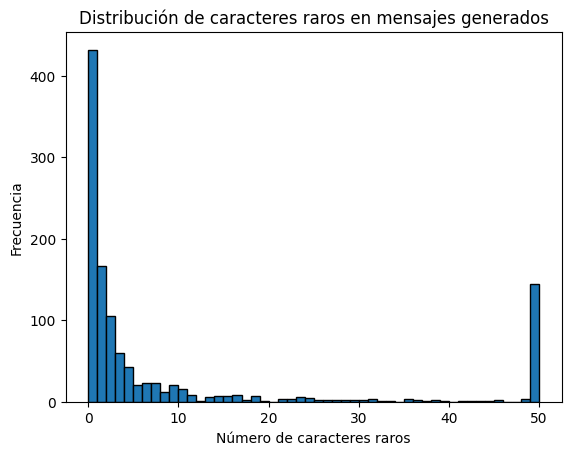

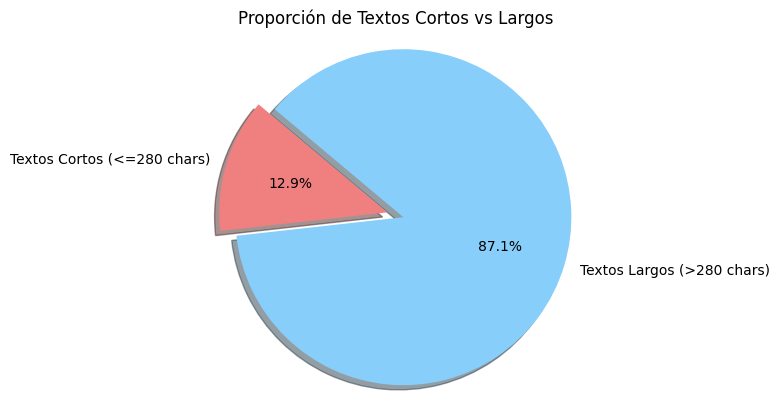

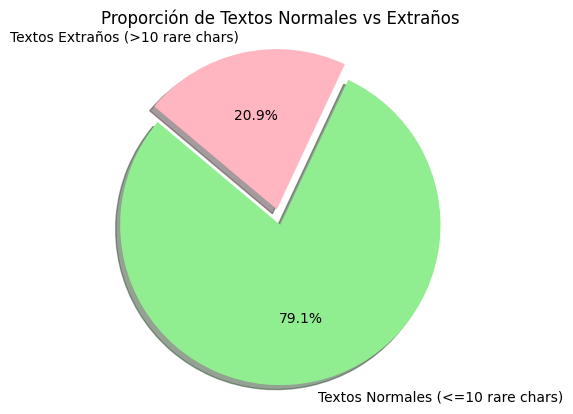

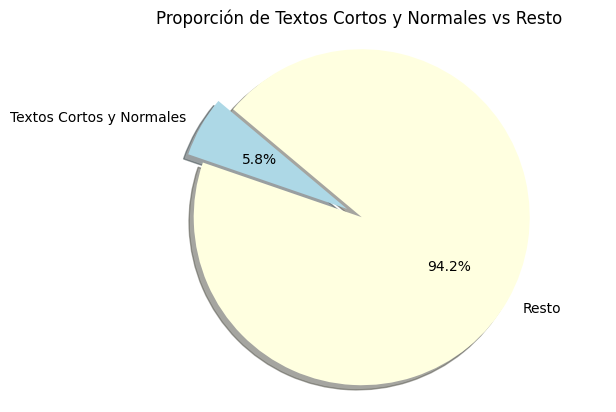


Tabla de Métricas:
Categoría                           Mean BLEU   Mean ROUGE-1   Mean ROUGE-L
--------------------------------------------------------------------------------
Textos Cortos (<=280 chars)         0.0033 0.0385 0.0368
Textos Largos (>280 chars)          0.0007     0.0058          0.0054    
Textos Normales (<=10 rare chars)   0.0008     0.0054          0.0051    
Textos Extraños (>10 rare chars)    0.0022     0.0276          0.0260    
Cortos y Normales                   0.0004     0.0026          0.0026    
Total                               0.0011     0.0100          0.0094    


In [30]:
main(allow_numbers=True)

Vuelvo a ejecutar pero esta vez sin contar los números como caracteres buenos:

-------------------------------------------------
Step 1 - Original: Full Movie:  Busty blonde Riley Steele parking bald cunt atop big cock for hardcore fuck...
Step 1 - Generated: omorphic the. 12. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31. 13. 14. 30. 31.
Step 1 - BLEU: 0.0000
Step 1 - ROUGE1: 0.0000
Step 1 - ROUGEL: 0.0000
-------------------------------------------------
Step 1 - Original: [USR] [USR] [USR] You better not, cunt  Ill flashbang u 😎
Step 1 - Generated: ale another a /. next best the [ orbing atben?idy. **38bit or 'bestbet 841/illing 2️#### or 41/30 Bet or 320 bet or 42Bet or 1/62 Bett or 1/43 bit or 1/23Bett or 1/53 Bet or 1/32bert or 1/28 Bit or 1/36 or 1/88 or 1/35 or 1/45 or 1/48 or 1/5 or 1/21 or

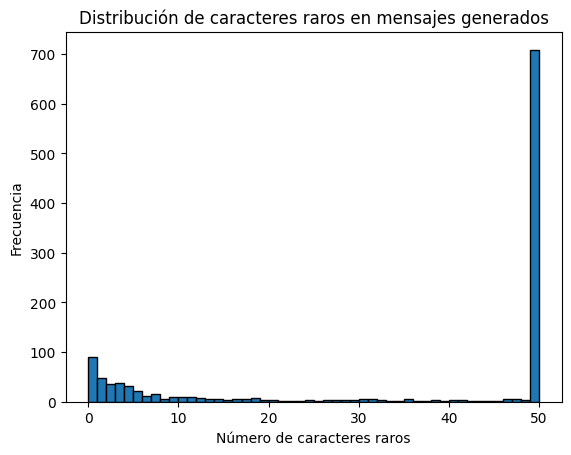

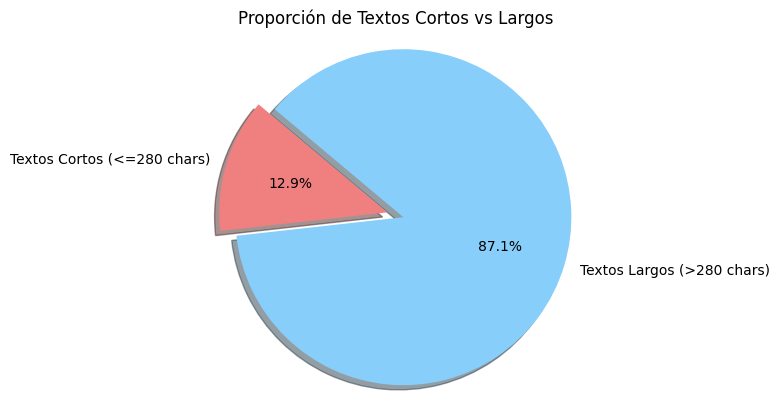

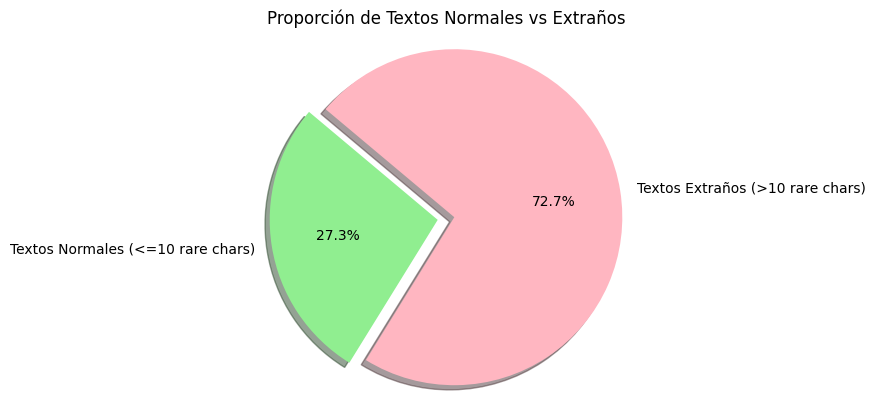

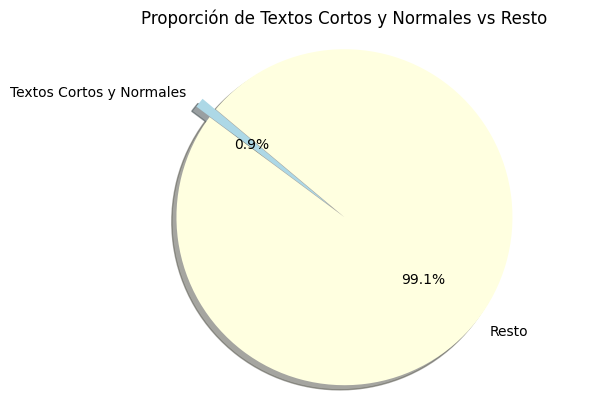


Tabla de Métricas:
Categoría                           Mean BLEU   Mean ROUGE-1   Mean ROUGE-L
--------------------------------------------------------------------------------
Textos Cortos (<=280 chars)         0.0033 0.0385 0.0368
Textos Largos (>280 chars)          0.0007     0.0058          0.0054    
Textos Normales (<=10 rare chars)   0.0011     0.0084          0.0080    
Textos Extraños (>10 rare chars)    0.0011     0.0107          0.0100    
Cortos y Normales                   0.0000     0.0000          0.0000    
Total                               0.0011     0.0100          0.0094    


In [31]:
main(allow_numbers=False)

Se puede apreciar que una gran parte de los textos incorrectos han tendido a generar números. Posiblemente un re-entrenamiento eliminando números en el preprocesado y/o penalizándolos en la generación pueda ser beneficioso.

# Exploración de términos más usadso

In [1]:
import re
from collections import Counter
import pandas as pd

# Función para leer y procesar el archivo
def read_steps_from_file_v2(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Patrón para capturar cada step y sus textos
    step_pattern = re.compile(r'Step (\d+) - Original: (.*?)\nStep \d+ - Generated: (.*?)(?=\nStep \d+ - Original: |\nValidation step \d+|$)', re.DOTALL)
    steps = step_pattern.findall(content)
    
    step_data = []
    for step in steps:
        step_number = step[0]
        original_text = step[1].strip()
        generated_text = step[2].strip()
        step_data.append((step_number, original_text, generated_text))
    return step_data

# Función para encontrar las palabras más usadas en los textos generados
def find_top_words(texts, top_n=10):
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(top_n)
    return most_common_words

# Función para contar en cuántos mensajes aparece cada palabra
def count_word_occurrences(texts, words):
    word_occurrences = {word: 0 for word, _ in words}
    for text in texts:
        words_in_text = set(re.findall(r'\b\w+\b', text.lower()))
        for word in words_in_text:
            if word in word_occurrences:
                word_occurrences[word] += 1
    return word_occurrences

def main_v2():
    # Leer el archivo y obtener los pasos
    file_path = 'full_val_records_llama.txt'
    steps = read_steps_from_file_v2(file_path)

    # Obtener los textos generados
    generated_texts = [step[2] for step in steps]

    # Encontrar las palabras más usadas
    top_words = find_top_words(generated_texts, top_n=10)

    # Contar en cuántos mensajes aparece cada palabra
    word_occurrences = count_word_occurrences(generated_texts, top_words)

    # Calcular el porcentaje de mensajes en los que aparece cada palabra
    total_messages = len(generated_texts)
    word_percentages = {word: (count / total_messages) * 100 for word, count in word_occurrences.items()}

    # Crear la tabla de resultados
    data = {
        'Palabra': [word for word, _ in top_words],
        'Nº de Mensajes': [word_occurrences[word] for word, _ in top_words],
        '% de Mensajes': [word_percentages[word] for word, _ in top_words]
    }

    df = pd.DataFrame(data)

    # Imprimir el total de mensajes
    print(f"Total de mensajes evaluados: {total_messages}\n")

    # Imprimir la tabla de resultados
    print(df.to_string(index=False))

if __name__ == "__main__":
    main_v2()


Total de mensajes evaluados: 1165

Palabra  Nº de Mensajes  % de Mensajes
     or             289      24.806867
      1             284      24.377682
      5             231      19.828326
      2             266      22.832618
    the             325      27.896996
     22             187      16.051502
      4             176      15.107296
    usr             115       9.871245
     25             167      14.334764
   next             165      14.163090


In [3]:
import re
from collections import Counter
import pandas as pd

# Función para leer y procesar el archivo
def read_steps_from_file_v2(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Patrón para capturar cada step y sus textos
    step_pattern = re.compile(r'Step (\d+) - Original: (.*?)\nStep \d+ - Generated: (.*?)(?=\nStep \d+ - Original: |\nValidation step \d+|$)', re.DOTALL)
    steps = step_pattern.findall(content)
    
    step_data = []
    for step in steps:
        step_number = step[0]
        original_text = step[1].strip()
        generated_text = step[2].strip()
        step_data.append((step_number, original_text, generated_text))
    return step_data

# Función para encontrar las palabras más usadas en los textos generados
def find_top_words(texts, top_n=10):
    stop_words = {'or', 'the', 'i', 'and', 'a', 'an', 'to', 'of', 'in', 'it', 'is', 'on', 'for', 'at', 'by', 'with', 'as', 'that', 'from', 'this', 'be', 'was', 'were', 'will', 'would', 'can', 'could', 'should', 'has', 'have', 'had', 'do', 'does', 'did'}
    
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        filtered_words = [word for word in words if len(word) >= 4 and word not in stop_words and not word.isdigit()]
        all_words.extend(filtered_words)
    
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(top_n)
    return most_common_words

# Función para contar en cuántos mensajes aparece cada palabra
def count_word_occurrences(texts, words):
    word_occurrences = {word: 0 for word, _ in words}
    for text in texts:
        words_in_text = set(re.findall(r'\b\w+\b', text.lower()))
        filtered_words_in_text = {word for word in words_in_text if len(word) >= 4 and not word.isdigit()}
        for word in filtered_words_in_text:
            if word in word_occurrences:
                word_occurrences[word] += 1
    return word_occurrences

def main_v2():
    # Leer el archivo y obtener los pasos
    file_path = 'full_val_records_llama.txt'
    steps = read_steps_from_file_v2(file_path)

    # Obtener los textos generados
    generated_texts = [step[2] for step in steps]

    # Encontrar las palabras más usadas
    top_words = find_top_words(generated_texts, top_n=10)

    # Contar en cuántos mensajes aparece cada palabra
    word_occurrences = count_word_occurrences(generated_texts, top_words)

    # Calcular el porcentaje de mensajes en los que aparece cada palabra
    total_messages = len(generated_texts)
    word_percentages = {word: (count / total_messages) * 100 for word, count in word_occurrences.items()}

    # Crear la tabla de resultados
    data = {
        'Palabra': [word for word, _ in top_words],
        'Nº de Mensajes': [word_occurrences[word] for word, _ in top_words],
        '% de Mensajes': [word_percentages[word] for word, _ in top_words]
    }

    df = pd.DataFrame(data)

    # Imprimir el total de mensajes
    print(f"Total de mensajes evaluados: {total_messages}\n")

    # Imprimir la tabla de resultados
    print(df.to_string(index=False))

if __name__ == "__main__":
    main_v2()


Total de mensajes evaluados: 1165

  Palabra  Nº de Mensajes  % de Mensajes
     next             165      14.163090
     time              64       5.493562
     week              18       1.545064
     isha              59       5.064378
  binding              19       1.630901
    water              14       1.201717
something               5       0.429185
     last              41       3.519313
     work              30       2.575107
     oron               1       0.085837


Ahora veamos la lista de palabras de odio y cuántas veces aparecen, para ver cómo de sesgado está el modelo.

In [4]:
import re
from collections import Counter
import pandas as pd

# Función para leer y procesar el archivo de pasos
def read_steps_from_file_v2(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Patrón para capturar cada step y sus textos
    step_pattern = re.compile(r'Step (\d+) - Original: (.*?)\nStep \d+ - Generated: (.*?)(?=\nStep \d+ - Original: |\nValidation step \d+|$)', re.DOTALL)
    steps = step_pattern.findall(content)
    
    step_data = []
    for step in steps:
        step_number = step[0]
        original_text = step[1].strip()
        generated_text = step[2].strip()
        step_data.append((step_number, original_text, generated_text))
    return step_data

# Función para leer los términos de odio del archivo
def read_hatespeech_keywords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        keywords = [line.strip() for line in file.readlines()]
    return keywords

# Función para encontrar las palabras más usadas en los textos generados
def find_top_words(texts, top_n=10):
    stop_words = {'or', 'the', 'i', 'and', 'a', 'an', 'to', 'of', 'in', 'it', 'is', 'on', 'for', 'at', 'by', 'with', 'as', 'that', 'from', 'this', 'be', 'was', 'were', 'will', 'would', 'can', 'could', 'should', 'has', 'have', 'had', 'do', 'does', 'did'}
    
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        filtered_words = [word for word in words if len(word) >= 4 and word not in stop_words and not word.isdigit()]
        all_words.extend(filtered_words)
    
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(top_n)
    return most_common_words

# Función para contar en cuántos mensajes aparece cada palabra
def count_word_occurrences(texts, words):
    word_occurrences = {word: 0 for word, _ in words}
    for text in texts:
        words_in_text = set(re.findall(r'\b\w+\b', text.lower()))
        filtered_words_in_text = {word for word in words_in_text if len(word) >= 4 and not word.isdigit()}
        for word in filtered_words_in_text:
            if word in word_occurrences:
                word_occurrences[word] += 1
    return word_occurrences

# Función para contar la aparición de términos de odio en los textos generados
def count_hatespeech_occurrences(texts, keywords):
    keyword_occurrences = {keyword: 0 for keyword in keywords}
    for text in texts:
        for keyword in keywords:
            if keyword in text.lower():
                keyword_occurrences[keyword] += 1
    return keyword_occurrences

def main_v2():
    # Leer el archivo y obtener los pasos
    steps_file_path = 'full_val_records_llama.txt'
    hatespeech_file_path = 'hatespeech_keywords.txt'
    
    steps = read_steps_from_file_v2(steps_file_path)
    keywords = read_hatespeech_keywords(hatespeech_file_path)

    # Obtener los textos generados
    generated_texts = [step[2] for step in steps]

    # Encontrar las palabras más usadas
    top_words = find_top_words(generated_texts, top_n=10)

    # Contar en cuántos mensajes aparece cada palabra
    word_occurrences = count_word_occurrences(generated_texts, top_words)

    # Calcular el porcentaje de mensajes en los que aparece cada palabra
    total_messages = len(generated_texts)
    word_percentages = {word: (count / total_messages) * 100 for word, count in word_occurrences.items()}

    # Contar la aparición de términos de odio en los textos generados
    hatespeech_occurrences = count_hatespeech_occurrences(generated_texts, keywords)

    # Crear la tabla de resultados
    data = {
        'Palabra': [word for word, _ in top_words],
        'Nº de Mensajes': [word_occurrences[word] for word, _ in top_words],
        '% de Mensajes': [word_percentages[word] for word, _ in top_words]
    }

    df = pd.DataFrame(data)

    # Imprimir el total de mensajes
    print(f"Total de mensajes evaluados: {total_messages}\n")

    # Imprimir la tabla de resultados
    print("Top 10 palabras más usadas en los textos generados:")
    print(df.to_string(index=False))

    # Imprimir la ocurrencia de términos de odio
    print("\nOcurrencia de términos de odio en los textos generados:")
    for keyword, count in hatespeech_occurrences.items():
        print(f"{keyword}: {count} mensajes")

if __name__ == "__main__":
    main_v2()


Total de mensajes evaluados: 1165

Top 10 palabras más usadas en los textos generados:
  Palabra  Nº de Mensajes  % de Mensajes
     next             165      14.163090
     time              64       5.493562
     week              18       1.545064
     isha              59       5.064378
  binding              19       1.630901
    water              14       1.201717
something               5       0.429185
     last              41       3.519313
     work              30       2.575107
     oron               1       0.085837

Ocurrencia de términos de odio en los textos generados:
asian drive: 0 mensajes
feminazi: 2 mensajes
sjw: 4 mensajes
WomenAgainstFeminism: 0 mensajes
blameonenotall: 0 mensajes
islam terrorism: 0 mensajes
notallmen: 0 mensajes
victimcard: 0 mensajes
victim card: 2 mensajes
arab terror: 0 mensajes
gamergate: 2 mensajes
jsil: 0 mensajes
racecard: 0 mensajes
race card: 0 mensajes
refugeesnotwelcome: 0 mensajes
DeportallMuslims: 0 mensajes
banislam: 0 mensajes
